In [39]:
from keras.datasets import boston_housing #导入波士顿房价数据集


(train_x, train_y), (test_x, test_y) = boston_housing.load_data()   # 加载数据，并划分为训练集、测试集

print(train_x.shape)  # 训练集样本及特征数
print(train_y.shape)  # 训练集标签数

print(test_x.shape)  # 测试样本及特征数
print(test_y.shape)  # 测试集标签数

(404, 13)
(404,)
(102, 13)
(102,)


In [46]:
import pandas as pd 
import pandas_profiling


#  特征名称
feature_name = ['CRIM|住房所在城镇的人均犯罪率',
 'ZN|住房用地超过 25000 平方尺的比例',
 'INDUS|住房所在城镇非零售商用土地的比例',
 'CHAS|有关查理斯河的虚拟变量（如果住房位于河边则为1,否则为0 ）',
 'NOX|一氧化氮浓度',
 'RM|每处住房的平均房间数',
 'AGE|建于 1940 年之前的业主自住房比例',
 'DIS|住房距离波士顿五大中心区域的加权距离',
 'RAD|距离住房最近的公路入口编号',
 'TAX 每 10000 美元的全额财产税金额',
 'PTRATIO|住房所在城镇的师生比例',
 'B|1000(Bk|0.63)^2,其中 Bk 指代城镇中黑人的比例',
 'LSTAT|弱势群体人口所占比例']

train_df = pd.DataFrame(train_x, columns=feature_name)  # 转为df格式
print("标签值范围",max(train_y),min(train_y))
pandas_profiling.ProfileReport(train_df)  

标签值范围 50.0 5.0


## 深度神经网络预测房价

隐藏层神经元数 5
验证集最优结果MSE： 18.8272762298584
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 13)                52        
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 70        
_________________________________________________________________
dropout_4 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 6         
Total params: 128
Trainable params: 102
Non-trainable params: 26
_________________________________________________________________


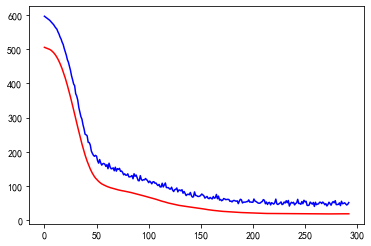

隐藏层神经元数 20
验证集最优结果MSE： 12.17193603515625
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 13)                52        
_________________________________________________________________
dense_9 (Dense)              (None, 20)                280       
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 21        
Total params: 353
Trainable params: 327
Non-trainable params: 26
_________________________________________________________________


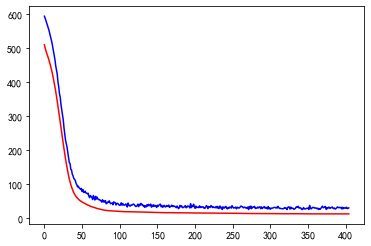

隐藏层神经元数 50
验证集最优结果MSE： 9.355822563171387
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, 13)                52        
_________________________________________________________________
dense_11 (Dense)             (None, 50)                700       
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 803
Trainable params: 777
Non-trainable params: 26
_________________________________________________________________


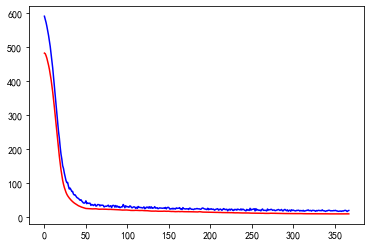

In [40]:
import numpy as np
import  matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import random
from keras import regularizers
from keras.layers import Dense,Dropout,BatchNormalization,GaussianNoise
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import  mean_squared_error

np.random.seed(1) # 固定随机种子，使每次运行结果固定
random.set_seed(1)


# 创建模型结构：输入层的特征维数为13；1层k个神经元的relu隐藏层；线性的输出层；

for k in [5,20,50]:  # 网格搜索超参数：神经元数
    print("隐藏层神经元数",k)
    model = Sequential()

    model.add(BatchNormalization())  # 输入层 批标准化 

    model.add(Dense(k,  
                    input_dim=13,
                    kernel_initializer='random_uniform',   # 均匀初始化
                    activation='relu',                     # relu激活函数
                    kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),  # L1及L2 正则项
                    use_bias=True))   # 隐藏层

    model.add(Dropout(0.1)) # dropout正则
    # model.add(GaussianNoise(0.1)) # 引入噪声正则
    
    model.add(Dense(1,use_bias=True))  # 输出层

    
    
    # 编译模型：优化目标为回归预测损失mse，优化算法为adam
    model.compile(optimizer='adam', loss='mse') 

    # 训练模型
    history = model.fit(train_x, 
                        train_y, 
                        epochs=500,              # 训练迭代次数
                        batch_size=50,           # 每epoch采样的batch大小
                        validation_split=0.1,   # 从训练集再拆分验证集，作为早停的衡量指标
                        callbacks=[EarlyStopping(monitor='val_loss', patience=20)],    #早停法
                        verbose=False)  # 不输出过程  

    
    print("验证集最优结果MSE：",min(history.history['val_loss']))
    model.summary()   #模型概述信息
    # 模型评估：拟合效果
    plt.plot(history.history['loss'],c='blue')    # 蓝色线训练集损失
    plt.plot(history.history['val_loss'],c='red') # 红色线验证集损失
    plt.show()
    

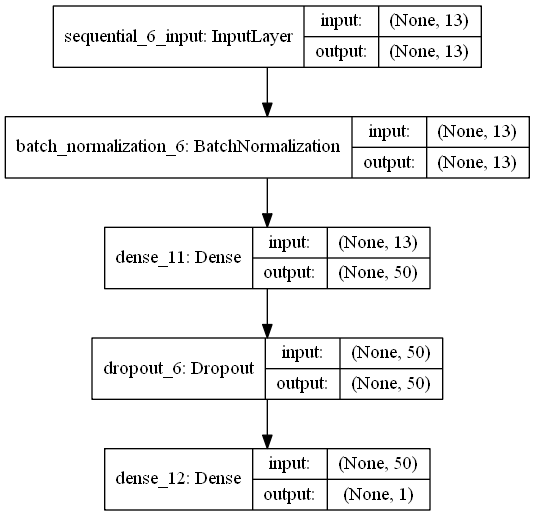

In [41]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True)

### 模型评估

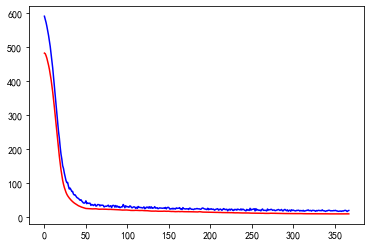

In [42]:
# 模型评估：拟合效果
import  matplotlib.pyplot as plt

plt.plot(history.history['loss'],c='blue')    # 蓝色线训练集损失
plt.plot(history.history['val_loss'],c='red') # 红色线验证集损失

In [43]:
# 模型评估：测试集预测结果
pred_y = model.predict(test_x)[:,0]

print("正确标签：",test_y)
print("模型预测：",pred_y )

print("实际与预测值的差异MSE：",mean_squared_error(test_y,pred_y ))

正确标签： [ 7.2 18.8 19.  27.  22.2 24.5 31.2 22.9 20.5 23.2 18.6 14.5 17.8 50.
 20.8 24.3 24.2 19.8 19.1 22.7 12.  10.2 20.  18.5 20.9 23.  27.5 30.1
  9.5 22.  21.2 14.1 33.1 23.4 20.1  7.4 15.4 23.8 20.1 24.5 33.  28.4
 14.1 46.7 32.5 29.6 28.4 19.8 20.2 25.  35.4 20.3  9.7 14.5 34.9 26.6
  7.2 50.  32.4 21.6 29.8 13.1 27.5 21.2 23.1 21.9 13.  23.2  8.1  5.6
 21.7 29.6 19.6  7.  26.4 18.9 20.9 28.1 35.4 10.2 24.3 43.1 17.6 15.4
 16.2 27.1 21.4 21.5 22.4 25.  16.6 18.6 22.  42.8 35.1 21.5 36.  21.9
 24.1 50.  26.7 25. ]
模型预测： [ 5.549633  19.139069  21.000252  33.869312  24.141079  19.670061
 28.705006  22.19373   19.117369  22.335001  15.985518  16.66321
 16.044024  40.10751   19.746256  19.235216  24.741789  19.907377
 18.848124  29.854937  11.826425  17.064634  21.079912  14.4903965
 20.505045  24.574642  31.08611   27.099892   9.76441   20.299303
 21.473028  14.507135  31.876432  23.194094  17.96339    9.062346
 12.91838   19.518394  19.867535  26.949326  28.184692  26.724247
 15.5219

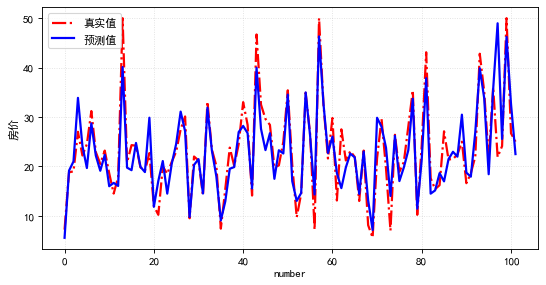

In [44]:
#绘图表示
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 设置图形大小
plt.figure(figsize=(8, 4), dpi=80)
plt.plot(range(len(test_y)), test_y, ls='-.',lw=2,c='r',label='真实值')
plt.plot(range(len(pred_y)), pred_y, ls='-',lw=2,c='b',label='预测值')

# 绘制网格
plt.grid(alpha=0.4, linestyle=':')
plt.legend()
plt.xlabel('number') #设置x轴的标签文本
plt.ylabel('房价') #设置y轴的标签文本

# 展示
plt.show()

### 模型解释性

In [67]:
import shap 
import tensorflow as tf  # tf版本<2.0 不然会有兼容性报错


# 模型解释性
background = test_x[np.random.choice(test_x.shape[0],10, replace=False)]
explainer = shap.GradientExplainer(model,  tf.constant(background,dtype='float32'))
shap_values = explainer.shap_values( test_x)  # 传入特征矩阵X，计算SHAP值
# 可视化第一个样本预测的解释  
shap.force_plot(explainer.expected_value, shap_values[0,:], test_x.iloc[0,:])

In [12]:
# import numpy as np
# import  matplotlib.pyplot as plt
# %matplotlib inline
# from tensorflow import random
# from keras import regularizers
# from keras.layers import Dense,Dropout,BatchNormalization
# from keras.models import Sequential, Model
# from keras.callbacks import EarlyStopping
# from sklearn.metrics import  mean_squared_error
# import keras_tuner as kt  # pip install keras_tuner 

# np.random.seed(1) # 固定随机种子，是每次运行结果固定
# random.set_seed(1)

# """
# 优化batchsize等超参数
# class MyTuner(kerastuner.tuners.BayesianOptimization):
#   def run_trial(self, trial, *args, **kwargs):
#     # You can add additional HyperParameters for preprocessing and custom training loops
#     # via overriding `run_trial`
#     kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 256, step=32)
#     kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 30)
#     super(MyTuner, self).run_trial(trial, *args, **kwargs)

# # Uses same arguments as the BayesianOptimization Tuner.
# tuner = MyTuner(...)
# # Don't pass epochs or batch_size here, let the Tuner tune them.
# tuner.search(...)
# """

##############################################keras_tuner 超参数搜索

# def build_model(hp): 
    
#     model = Sequential()

#     model.add(BatchNormalization(input_dim=13))  # 输入层 批标准化 

#     model.add(Dense(hp.Choice('units', [8, 16, 32]),  
#                     kernel_initializer='random_uniform',   # 均匀初始化
#                     activation='relu',                     # relu激活函数
#                     kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),  # L1及L2 正则项
#                     use_bias=True))   # 隐藏层

#     model.add(Dropout(0.1)) # dropout法

#     model.add(Dense(1,use_bias=True))  # 输出层


#     # 编译模型：优化目标为回归预测损失mse，优化算法为adam
#     model.compile(optimizer='adam', 
#                   loss='mse') 
#     return model
 
    
# tuner = kt.RandomSearch(
#     build_model,
#     objective='val_loss',
#     max_trials=5)
# tuner.search(train_x, train_y, epochs=200, validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=20)])
# best_model = tuner.get_best_models()[0]  
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]   

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit
